In [1]:
import os
if os.getcwd().split("/")[-1] != "neurolib":
    os.chdir('..')

os.chdir('..')
datadir = os.path.join(os.getcwd(), "neurolib", "notebooks_frontiers24")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from numba.typed import Dict
from numba.core import types

# We import the model, stimuli, and the optimal control package
from neurolib.models.aln import ALNModel

from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_aln, cost_functions

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

weights = Dict.empty(
        key_type=types.unicode_type,
        value_type=types.float64,
    )

weights["w_2"] = 1.0
weights["w_1D"] = 0.0

def plot_control(c, s, dur, dt, filename=None, title=None):
    fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True)
    time_array = np.arange(0, dur+dt, dt)

    cmax = np.amax(np.abs(c))
    y1lim = [-cmax* 1.1, cmax* 1.1]

    for n in range(N):
        ax[0].plot(time_array, s[n,0,:], color="red")
        ax[1].plot(time_array, c[n,0,:], color="red")
        ax[1].plot(time_array, c[n,1,:], color="blue")

    ax[0].set_xlim(0, dur)

    ax[1].set_ylim(y1lim)

    ax[1].set_xlabel("Time")
    ax[0].set_ylabel("Activity")
    ax[1].set_ylabel("Control")

    plt.subplots_adjust(
                    wspace=0.15,
                    hspace=0.1)
    
    fig.align_ylabels([ax[0]])
    
    if title is not None:
        fig.suptitle(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', dpi=200)

    plt.show()
    return

# This function reads out the final state of a simulation
def getfinalstate(model):
    N = model.params.Cmat.shape[0]
    V = len(model.state_vars)
    T = model.getMaxDelay() + 1
    state = np.zeros((N, V, T))
    for v in range(V):
        if "rates" in model.state_vars[v] or "IA" in model.state_vars[v]:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n, -T:]
        else:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n]
    return state

# This function sets the initial state of a model to specific values
def setinitstate(model, state):
    N = model.params.Cmat.shape[0]
    V = len(model.init_vars)
    T = model.getMaxDelay() + 1

    for n in range(N):
        for v in range(V):
            if "rates" in model.init_vars[v] or "IA" in model.init_vars[v]:
                model.params[model.init_vars[v]] = state[:, v, -T:]
            else:
                model.params[model.init_vars[v]] = state[:, v, -1]

    return

# This function reads the complete state of the EIF model
def getstate(model):
    state = np.concatenate(  ( np.concatenate((model.params["rates_exc_init"][:, np.newaxis, -1],
                                            model.params["rates_inh_init"][:, np.newaxis, -1],
                                            model.params["IA_init"][:, np.newaxis, -1], ), axis=1, )[:, :, np.newaxis],
                            np.stack((model.rates_exc, model.rates_inh, model.IA), axis=1),),axis=2,  )
    
    return state

def getperiod(data, dt):
    maxfreq = []
    for i_d,d in enumerate(data):
        ps = np.abs(np.fft.fft(d))
        ps_ = ps[:int(len(ps)/2)] / (len(ps)/2)
        ps_[0] = 0.
        fr = np.linspace(0,1./(2.*dt),len(ps_))
        maxfreqind = np.where(ps_ == max(ps_[1:]))
        maxfreq.append((1./fr[maxfreqind])[0])

    return np.mean(maxfreq)

def adjust_weight(model_controlled, weight):
    coc = cost_functions.control_strength_cost(model_controlled.control.copy(), weights, dt)
    fsync = (model_controlled.compute_total_cost() - coc)/weight
    weight = (-1e-6 - coc)/fsync # adjust weight such that cost remains negative
    print("weight = ", weight)
    model_controlled.weights["w_f_osc"] = weight
    return weight

def adjust_weight_1(model_controlled, ucc, weight):
    coc = cost_functions.control_strength_cost(model_controlled.control.copy(), weights, dt)
    F = model_controlled.compute_total_cost()
    fsync = (F - coc)/weight
    weight = (1. + 1e-9) * coc/ (ucc - fsync)
    model_controlled.weights["w_f_osc"] = weight
    return weight

In [6]:
data = dict()
coords = [1.9, 1.5]

data = dict()
data["coordinates"] = coords
data["control"] = [None, None]
data["state"] = [None, None]
data["control_unshifted"] = [None, None]
data["state_unshifted"] = [None, None]
data["energy_input_unshifted"] = np.zeros((2))
data["Fourier_cost_unshifted"] = np.zeros((2))
data["init_state"] = [None, None]
data["energy_input"] = np.zeros((2))
data["Fourier_cost"] = np.zeros((2))
data["weights"] = np.zeros((2))

N = 1
model = ALNModel()
dt = model.params.dt

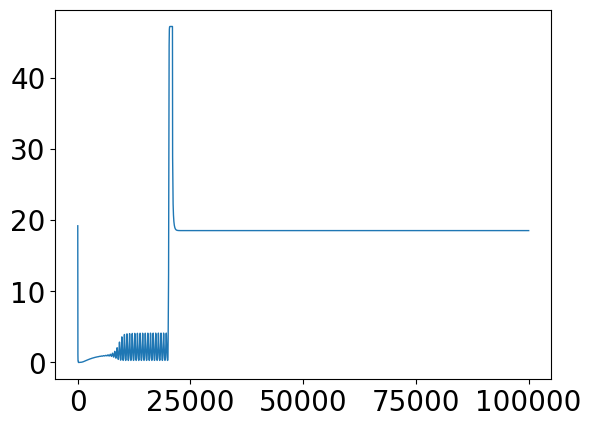

natural period =  58.06322580645162
[2.54665949 2.57232942 2.59783168 2.62315769 2.64829684 2.67595235
 2.7036275  2.731123   2.75843035 2.785541  ]


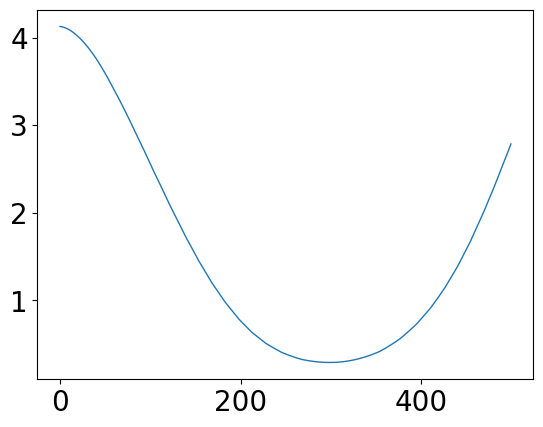

In [74]:
model = ALNModel()
testd = 1.*1e4
model.params.duration = testd
model.params.mue_ext_mean = data["coordinates"][0]
model.params.mui_ext_mean = data["coordinates"][1]

test_input = ZeroInput().generate_input(duration=testd+model.params.dt, dt=model.params.dt)
test_input[0,int(2000/dt):int(2100/dt)] = .6
model.params["ext_exc_current"] = test_input
model.params["ext_inh_current"] = test_input

model.run()
model.run()
plt.plot(model.rates_exc[0,:])
plt.show()

data["init_state"][0] = getfinalstate(model)

test_input[0,int(2000/dt):int(2100/dt)] = -0.3

model.params["ext_exc_current"] = test_input
model.params["ext_inh_current"] = test_input

model.run()
plt.plot(model.rates_exc[0,-500:])

data["init_state"][1] = getfinalstate(model)

natural_period = getperiod([model.rates_exc[0,int(1000/dt):]], dt)
print("natural period = ", natural_period)

print(data["init_state"][1][0,0,-10:])

In [8]:
controlmat = np.zeros((N,4))
controlmat[0,0] = 1

costmat = np.zeros((N, 3))
costmat[:,0] = 1.

duration = 1000.
int0 = 1000
int1 = 5000
int2 = 6000

max_cntrl = 5
pr = np.arange(0,101,10)

In [44]:
with open(os.path.join(datadir, '3_2_1.pickle'), 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys())

data = res_read.copy()

dict_keys(['coordinates', 'control', 'state', 'control_unshifted', 'state_unshifted', 'init_state', 'energy_input', 'Fourier_cost', 'weights', 'energy_input_unshifted', 'Fourier_cost_unshifted'])


In [145]:
data["weights"][0] = 1e3
data["weights"][1] = -1

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -1.2505752353476785e-26
Final cost : -1.2505752353476785e-26
Compute control for a deterministic system
Cost in iteration 0: -1.2505752353476785e-26
Converged in iteration 1 with cost -1.2505752353476785e-26
Final cost : -1.2505752353476785e-26
Compute control for a deterministic system
Cost in iteration 0: -1.2505752353476785e-26
Converged in iteration 4 with cost -692.9253108391642
Final cost : -692.9253108391642
weight =  186.1102349658849
Compute control for a deterministic system
Cost in iteration 0: -1.0000000258969521e-06
Final cost : -5.186513905074349
weight =  967.2634387907568


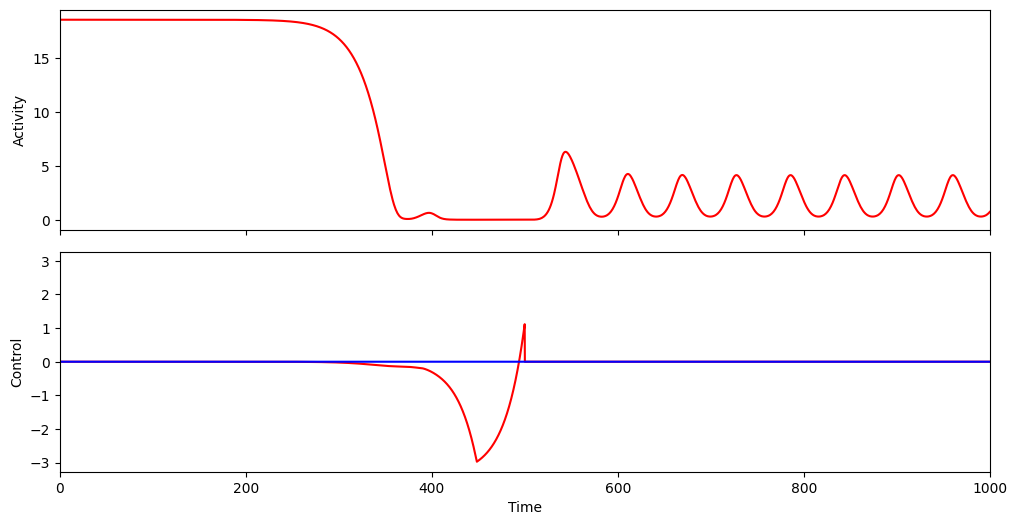

In [125]:
ci = 0 # up to osc task

model = ALNModel()
setinitstate(model, data["init_state"][ci])
model.params["mue_ext_mean"] =  data["coordinates"][0]
model.params["mui_ext_mean"] =  data["coordinates"][1]
model.params.duration = duration

model.run()

model_controlled = oc_aln.OcAln(model, natural_period, print_array=pr, cost_interval=(int2,None), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_2"] = 1.
model_controlled.weights["w_f_osc"] = data["weights"][ci]
model_controlled.maximum_control_strength = max_cntrl
model_controlled.optimize(0)

for k in [0,4]:
    model_controlled.zero_step_encountered = False
    model_controlled.step = 10**(k)
    model_controlled.optimize(4)

w_f = adjust_weight(model_controlled, data["weights"][ci])
model_controlled.zero_step_encountered = False
model_controlled.step = 10**(-2)
model_controlled.optimize(1)

w_f = adjust_weight(model_controlled, data["weights"][ci])
model_controlled.grad_method = 1
for k in np.arange(-4., 4., 1.):
    break
    model_controlled.zero_step_encountered = False
    model_controlled.step = 10**(k)
    model_controlled.optimize(10)

data["control_unshifted"][ci] = model_controlled.control.copy()
data["state_unshifted"][ci] = model_controlled.get_xs()

data["energy_input_unshifted"][ci] = cost_functions.control_strength_cost(data["control"][ci], weights, dt)
data["Fourier_cost_unshifted"][ci] = (model_controlled.compute_total_cost() - data["energy_input"][ci])/data["weights"][ci]
plot_control(model_controlled.control, model_controlled.get_xs(), duration, dt, filename=None, title=None)

In [ ]:
# rerun until convergence - this might require MANY iterations
ci = 0 # up to osc task

model = ALNModel()
setinitstate(model, data["init_state"][ci])
model.params["mue_ext_mean"] =  data["coordinates"][0]
model.params["mui_ext_mean"] =  data["coordinates"][1]
model.params.duration = duration

model.run()

model_controlled = oc_aln.OcAln(model, natural_period, print_array=pr, cost_interval=(int2,None), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_2"] = 1.
model_controlled.weights["w_f_osc"] = data["weights"][ci]

model_controlled.maximum_control_strength = max_cntrl

model_controlled.control = data["control_unshifted"][ci].copy()
model_controlled.update_input()
model_controlled.optimize(1)

for j in range(1):
    #data["weights"][ci] = adjust_weight(model_controlled, data["weights"][ci])

    model_controlled.grad_method = 0
    for k in np.arange(-4., 5., 2.):
        model_controlled.zero_step_encountered = False
        model_controlled.step = 10**(k)
        model_controlled.optimize(2)
        
    model_controlled.grad_method = 1
    for k in np.arange(-4., 5., 2.):
        break
        model_controlled.zero_step_encountered = False
        model_controlled.step = 10**(k)
        model_controlled.optimize(10)

    if cost_functions.control_strength_cost(model_controlled.control, weights, dt) > 1e-2:
        data["control_unshifted"][ci] = model_controlled.control.copy()
        data["state_unshifted"][ci] = model_controlled.get_xs()

data["energy_input_unshifted"][ci] = cost_functions.control_strength_cost(data["control"][ci], weights, dt)
data["Fourier_cost_unshifted"][ci] = (model_controlled.compute_total_cost() - data["energy_input"][0])/data["weights"][ci]
plot_control(model_controlled.control, model_controlled.get_xs(), duration, dt, filename=None, title=None)

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -1.000000000001e-06
Final cost : -1.000000000001e-06
weight =  0.04323114629577584
Compute control for a deterministic system
Cost in iteration 0: -1.000000000001e-06
Converged in iteration 2 with cost -1.0219934876778969e-06
Final cost : -1.0219934876778969e-06
Compute control for a deterministic system
Cost in iteration 0: -1.0219934876778969e-06
Converged in iteration 1 with cost -1.0219934876778969e-06
Final cost : -1.0219934876778969e-06
Compute control for a deterministic system
Cost in iteration 0: -1.0219934876778969e-06
Converged in iteration 1 with cost -1.0219934876778969e-06
Final cost : -1.0219934876778969e-06
Compute control for a deterministic system
Cost in iteration 0: -1.0219934876778969e-06
Converged in iteration 1 with cost -1.0219934876778969e-06
Final cost : -1.0219934876778969e-06
Compute control for a deterministic system
Cost in iteration 0: -1.0219934

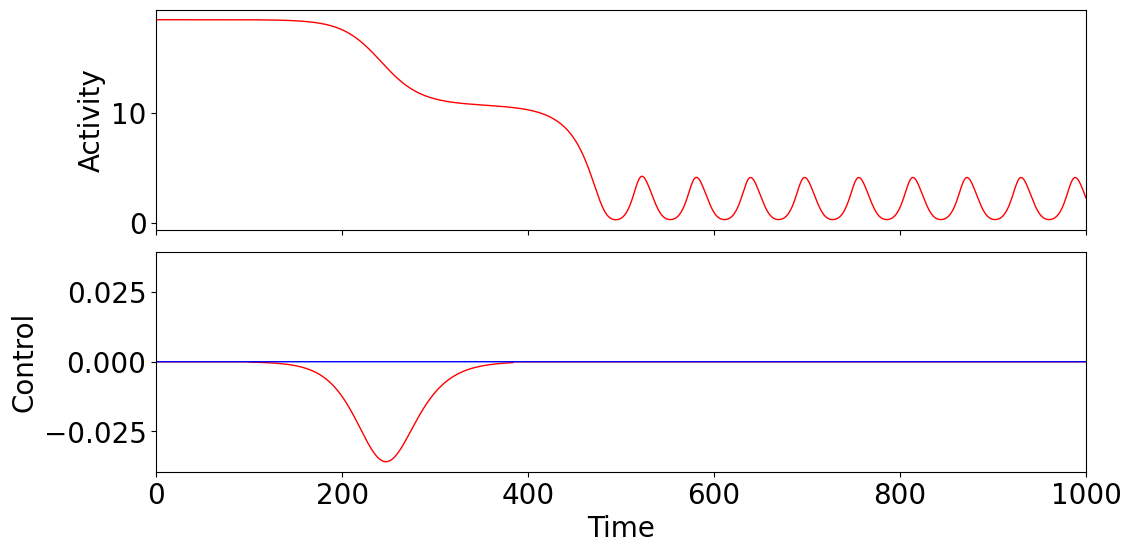

0.03662742791154193 -0.8472699209599402


In [177]:
# shift back in time by 2 periods and re-optimize
ci = 0 # up to osc task

model = ALNModel()
setinitstate(model, data["init_state"][ci])
model.params["mue_ext_mean"] =  data["coordinates"][0]
model.params["mui_ext_mean"] =  data["coordinates"][1]
model.params.duration = duration

model.run()

model_controlled = oc_aln.OcAln(model, natural_period, print_array=pr, cost_interval=(int2,None), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_2"] = 1.
model_controlled.weights["w_f_osc"] = data["weights"][ci]

model_controlled.maximum_control_strength = max_cntrl

shift_ind = int(2*natural_period/dt)
model_controlled.control[0,0,:-shift_ind] =  data["control_unshifted"][ci].copy()[0,0,shift_ind:]
model_controlled.update_input()
model_controlled.optimize(0)

for j in range(1):
    data["weights"][ci] = adjust_weight(model_controlled, data["weights"][ci])
    
    model_controlled.grad_method = 0
    for k in np.arange(-4., 5., 2.):
        model_controlled.zero_step_encountered = False
        model_controlled.step = 10**(k)
        model_controlled.optimize(10)

    model_controlled.grad_method = 1
    for k in np.arange(-4., 5., 2.):
        model_controlled.zero_step_encountered = False
        model_controlled.step = 10**(k)
        model_controlled.optimize(10)

data["control"][ci] = model_controlled.control.copy()
data["state"][ci] = model_controlled.get_xs()

data["energy_input"][ci] = cost_functions.control_strength_cost(data["control"][ci], weights, dt)
data["Fourier_cost"][ci] = (model_controlled.compute_total_cost() - data["energy_input"][ci])/data["weights"][ci]
plot_control(model_controlled.control, model_controlled.get_xs(), duration, dt, filename=None, title=None)

print(data["energy_input"][ci], data["Fourier_cost"][ci])

In [38]:
with open(os.path.join(datadir, '3_2_1.pickle'), 'wb') as f:
    pickle.dump(data, f)

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 0.8053204996620867
Final cost : 0.8053204996620867
Compute control for a deterministic system
Cost in iteration 0: 0.8053204996620867
Converged in iteration 3 with cost 0.8011106815241821
Final cost : 0.8011106815241821
1.1006296718851876
Compute control for a deterministic system
Cost in iteration 0: 0.8011106815241821
Cost in iteration 10: 0.09112820835763356
Final cost : 0.09112820835763356
0.07801871255733354
Compute control for a deterministic system
Cost in iteration 0: 0.09112820835763356
Cost in iteration 10: 0.08432443061083933
Final cost : 0.08432443061083933
0.053722706127493004


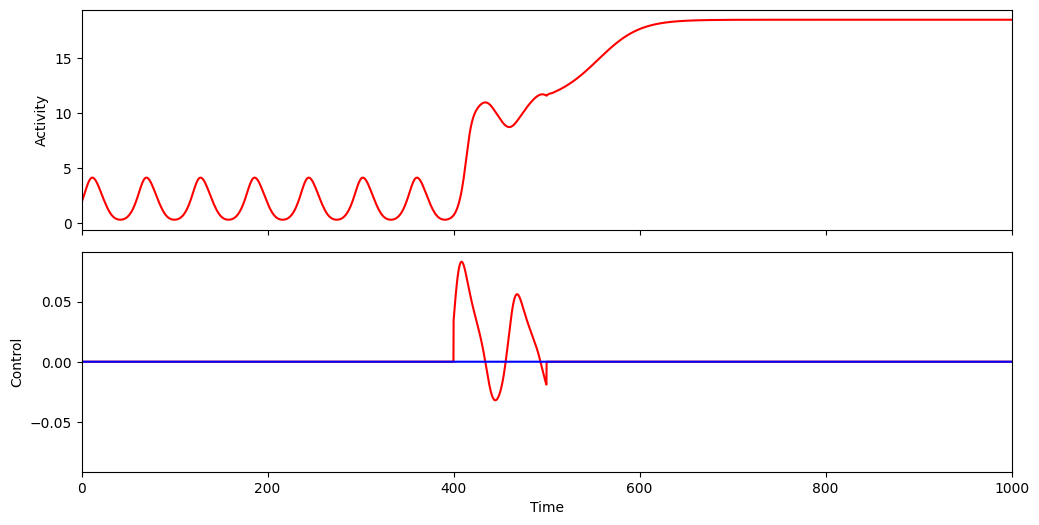

In [150]:
ci = 1 # osc to up task
data["weights"][ci] = -1.

model = ALNModel()
setinitstate(model, data["init_state"][ci])
model.params["mue_ext_mean"] =  data["coordinates"][0]
model.params["mui_ext_mean"] =  data["coordinates"][1]
model.params.duration = duration

model.run()

model_controlled = oc_aln.OcAln(model, natural_period, print_array=pr, cost_interval=(int2,None), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_2"] = 1.
model_controlled.weights["w_f_osc"] = data["weights"][ci]
model_controlled.maximum_control_strength = max_cntrl
model_controlled.optimize(0)

model_controlled.control_interval = (4000, int1)

for k in np.arange(-3.,3.,2.):
    model_controlled.gradient_method = 1
    model_controlled.zero_step_encountered = False
    model_controlled.step = 10**(k)
    model_controlled.optimize(10)
    print(np.amax(np.abs(model_controlled.gradient)))

data["control"][ci] = model_controlled.control.copy()
data["state"][ci] = model_controlled.get_xs()

data["energy_input"][ci] = cost_functions.control_strength_cost(data["control"][ci], weights, dt)
data["Fourier_cost"][ci] = (model_controlled.compute_total_cost() - data["energy_input"][ci])/data["weights"][ci]
plot_control(model_controlled.control, model_controlled.get_xs(), duration, dt, filename=None, title=None)

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 0.8053204996620867
Final cost : 0.8053204996620867
Compute control for a deterministic system
Cost in iteration 0: 0.040400574770169256
Final cost : 0.040400574770169256
Compute control for a deterministic system
Cost in iteration 0: 0.040400574770169256
Converged in iteration 1 with cost 0.040400574770169256
Final cost : 0.040400574770169256
Compute control for a deterministic system
Cost in iteration 0: 0.040400574770169256
Converged in iteration 1 with cost 0.040400574770169256
Final cost : 0.040400574770169256
Compute control for a deterministic system
Cost in iteration 0: 0.040400574770169256
Converged in iteration 1 with cost 0.040400574770169256
Final cost : 0.040400574770169256
Compute control for a deterministic system
Cost in iteration 0: 0.040400574770169256
Converged in iteration 1 with cost 0.040400574770169256
Final cost : 0.040400574770169256
Compute control for

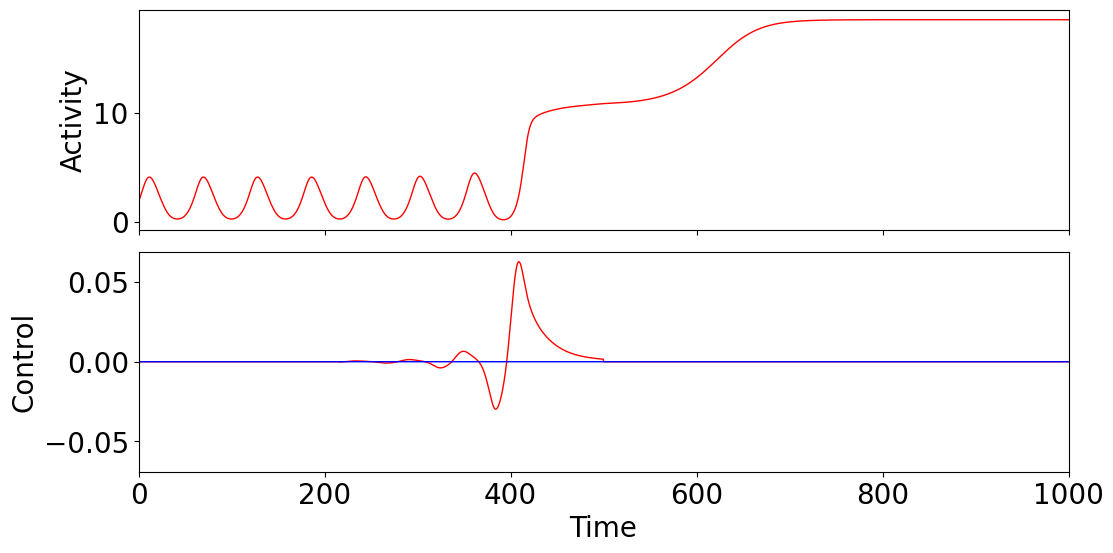

In [188]:
# rerun until convergence
ci = 1 # osc to up task

model = ALNModel()
setinitstate(model, data["init_state"][ci])
model.params["mue_ext_mean"] =  data["coordinates"][0]
model.params["mui_ext_mean"] =  data["coordinates"][1]
model.params.duration = duration

model.run()

model_controlled = oc_aln.OcAln(model, natural_period, print_array=pr, cost_interval=(int2,None), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_2"] = 1.
model_controlled.weights["w_f_osc"] = -1.
model_controlled.maximum_control_strength = max_cntrl

model_controlled.optimize(0)
ucc = -model_controlled.compute_total_cost()

model_controlled.control = data["control_unshifted"][ci].copy()
model_controlled.update_input()
model_controlled.weights["w_f_osc"] = data["weights"][ci]
model_controlled.optimize(0)

for j in range(1):
    data["weights"][ci] = adjust_weight_1(model_controlled, ucc, data["weights"][ci])

    model_controlled.grad_method = 0
    for k in np.arange(-4., 5., 2.):
        model_controlled.zero_step_encountered = False
        model_controlled.step = 10**(k)
        model_controlled.optimize(10)

    model_controlled.grad_method = 1
    for k in np.arange(-4., 5., 2.):
        model_controlled.zero_step_encountered = False
        model_controlled.step = 10**(k)
        model_controlled.optimize(10)

    if cost_functions.control_strength_cost(model_controlled.control, weights, dt) > 1e-2:
        data["control_unshifted"][ci] = model_controlled.control.copy()
        data["state_unshifted"][ci] = model_controlled.get_xs()

data["energy_input_unshifted"][ci] = cost_functions.control_strength_cost(data["control"][ci], weights, dt)
data["Fourier_cost_unshifted"][ci] = (model_controlled.compute_total_cost() - data["energy_input"][ci])/data["weights"][ci]
plot_control(model_controlled.control, model_controlled.get_xs(), duration, dt, filename=None, title=None)

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 0.8053204996620867
Final cost : 0.8053204996620867
Compute control for a deterministic system
Cost in iteration 0: 0.03961788550493028
Final cost : 0.03961788550493028
Compute control for a deterministic system
Cost in iteration 0: 0.03961788550493028
Converged in iteration 2 with cost 0.039617797968999585
Final cost : 0.039617797968999585
Compute control for a deterministic system
Cost in iteration 0: 0.039617797968999585
Converged in iteration 1 with cost 0.039617797968999585
Final cost : 0.039617797968999585
Compute control for a deterministic system
Cost in iteration 0: 0.039617797968999585
Converged in iteration 1 with cost 0.039617797968999585
Final cost : 0.039617797968999585
Compute control for a deterministic system
Cost in iteration 0: 0.039617797968999585
Converged in iteration 1 with cost 0.039617797968999585
Final cost : 0.039617797968999585
Compute control for a 

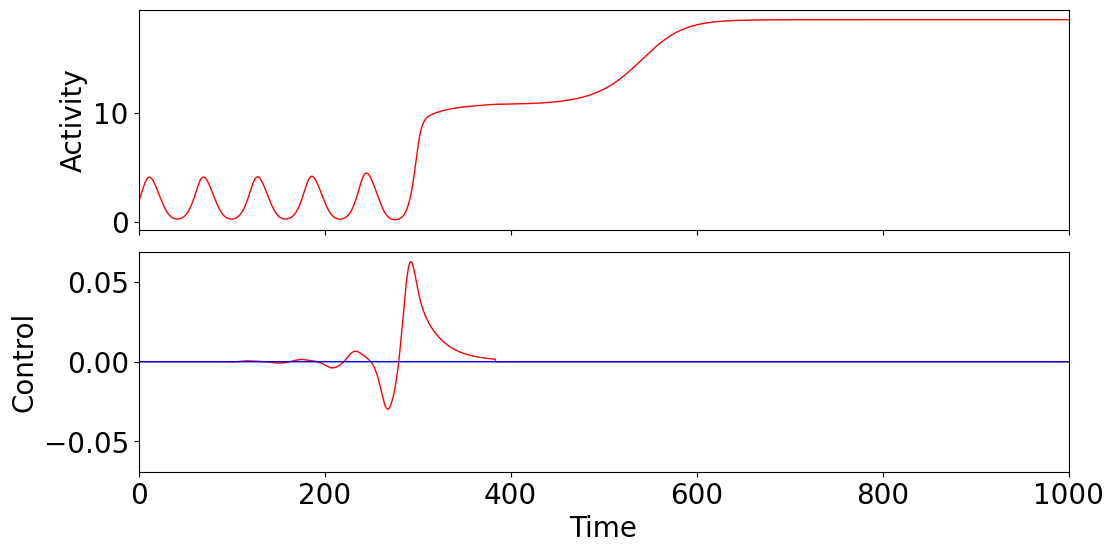

In [178]:
# shift back in time by 2 periods and re-optimize
ci = 1 # up to osc task

model = ALNModel()
setinitstate(model, data["init_state"][ci])
model.params["mue_ext_mean"] =  data["coordinates"][0]
model.params["mui_ext_mean"] =  data["coordinates"][1]
model.params.duration = duration

model.run()

model_controlled = oc_aln.OcAln(model, natural_period, print_array=pr, cost_interval=(int2,None), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_2"] = 1.
model_controlled.weights["w_f_osc"] = -1.
model_controlled.maximum_control_strength = max_cntrl

model_controlled.optimize(0)
ucc = -model_controlled.compute_total_cost()

model_controlled.weights["w_f_osc"] = data["weights"][ci]

shift_ind = int(2*natural_period/dt)
model_controlled.control[0,0,:-shift_ind] =  data["control_unshifted"][ci].copy()[0,0,shift_ind:]
model_controlled.update_input()
model_controlled.optimize(0)

for j in range(1):
    data["weights"][ci] = adjust_weight_1(model_controlled, ucc, data["weights"][ci])
    
    model_controlled.grad_method = 0
    for k in np.arange(-4., 5., 2.):
        model_controlled.zero_step_encountered = False
        model_controlled.step = 10**(k)
        model_controlled.optimize(10)

    model_controlled.grad_method = 1
    for k in np.arange(-4., 5., 2.):
        model_controlled.zero_step_encountered = False
        model_controlled.step = 10**(k)
        model_controlled.optimize(10)

data["control"][ci] = model_controlled.control.copy()
data["state"][ci] = model_controlled.get_xs()

data["energy_input"][ci] = cost_functions.control_strength_cost(data["control"][ci], weights, dt)
data["Fourier_cost"][ci] = (model_controlled.compute_total_cost() - data["energy_input"][ci])/data["weights"][ci]
plot_control(model_controlled.control, model_controlled.get_xs(), duration, dt, filename=None, title=None)

In [167]:
with open(os.path.join(datadir, '3_2_1.pickle'), 'wb') as f:
    pickle.dump(data, f)

In [9]:
with open(os.path.join(datadir, '3_2_1.pickle'), 'rb') as f:
    res_read = pickle.load(f)

data = res_read.copy()

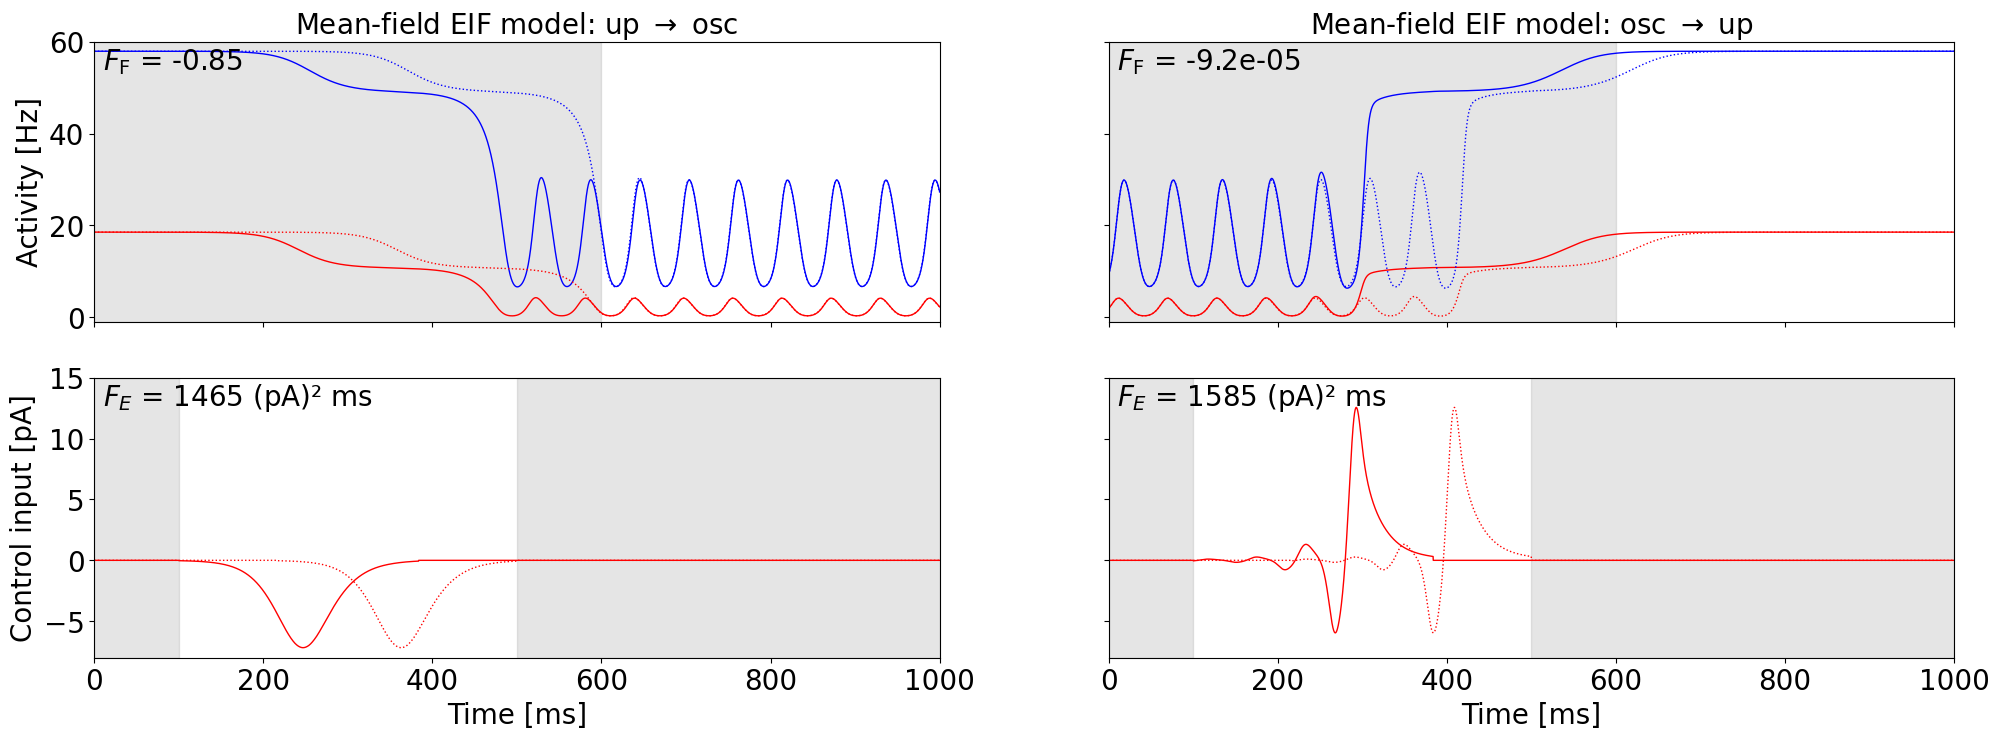

In [32]:
import matplotlib as mpl
label_size= 20
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['font.size'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.linewidth'] = 1

fig, ax = plt.subplots(2,2, figsize=(24,8), sharex=True, sharey="row")

ax[0,0].set_title(r"Mean-field EIF model: up $\rightarrow$ osc")
ax[0,1].set_title(r"Mean-field EIF model: osc $\rightarrow$ up")

time = np.arange(0, duration+dt, dt)

for ci in range(2):
    ax[0,ci].plot(time, data["state"][ci][0,0,:], color="red", label="E")
    ax[0,ci].plot(time, data["state"][ci][0,1,:], color="blue", label="I")
    ax[1,ci].plot(time, 200*data["control"][ci][0,0,:], color="red")

    ax[0,ci].plot(time, data["state_unshifted"][ci][0,0,:], color="red", label="E", linestyle=":")
    ax[0,ci].plot(time, data["state_unshifted"][ci][0,1,:], color="blue", label="I", linestyle=":")
    ax[1,ci].plot(time, 200*data["control_unshifted"][ci][0,0,:], color="red", linestyle=":")


ax[0,0].set_label("upper right")

ax[1,0].set_xlabel("Time [ms]")
ax[1,1].set_xlabel("Time [ms]")
ax[0,0].set_ylabel("Activity [Hz]")
ax[1,0].set_ylabel("Control input [pA]")

ax[0,0].set_xlim(0, duration)

ax[0,0].set_ylim(-1,60)
ax[1,0].set_ylim(-8,15)

alpha=0.2
for ci in range(2):
    ax[0,ci].axvspan(0, 600, color="grey", alpha=alpha)
    ax[1,ci].axvspan(500, 1000, color="grey", alpha=alpha)
    ax[1,ci].axvspan(0, 100, color="grey", alpha=alpha)

    ax[1,ci].text(0.01, 0.9, r"$F_E$ = " + "{0:.0f}".format(200**2*data["energy_input"][ci]) + " (pA)² ms", transform=ax[1,ci].transAxes)
    ax[0,ci].text(0.01, 0.9, r"$F_\text{F}$ = " + "{0:.2g}".format(data["Fourier_cost"][ci]), transform=ax[0,ci].transAxes)

plt.savefig(os.path.join(datadir, "Fig_6.jpg"), bbox_inches='tight', dpi=300)

In [192]:
### improvement and weights

print(1. - data["Fourier_cost"][0]/data["Fourier_cost_unshifted"][0], 1. - data["Fourier_cost"][1]/data["Fourier_cost_unshifted"][1])
print(data["weights"])

0.006732813055128295 0.9935638353063124
[ 0.04294005 -0.05016713]


In [ ]:
with open(os.path.join(datadir, '3_2_1_loc_opt.pickle'), 'rb') as f:
    res_read = pickle.load(f)

[loc_opt_control, loc_opt_state, loc_opt_weight] = res_read.copy()

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 82.15179169028525
Final cost : 82.15179169028525
Compute control for a deterministic system
Cost in iteration 0: 86.43387438848454
Converged in iteration 8 with cost 0.3975677042461788
Final cost : 0.3975677042461788


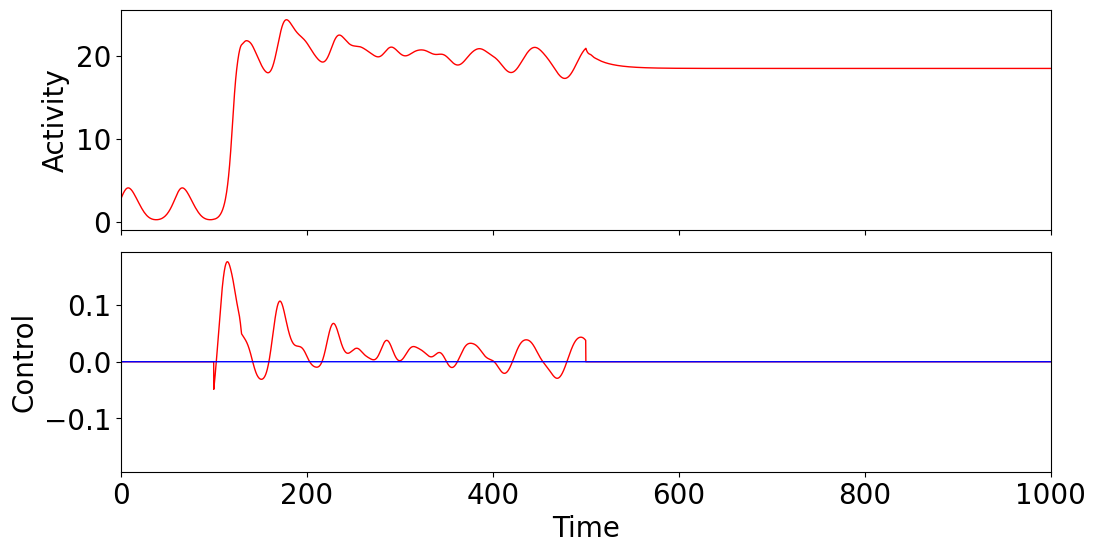

In [171]:
# LOCAL OPTIMUM

loc_opt_weight = -100.

model = ALNModel()
setinitstate(model, data["init_state"][1])
model.params["mue_ext_mean"] =  data["coordinates"][0]
model.params["mui_ext_mean"] =  data["coordinates"][1]
model.params.duration = duration

model.run()

model_controlled = oc_aln.OcAln(model, natural_period, print_array=pr, cost_interval=(int2,None), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_2"] = 1.
model_controlled.weights["w_f_osc"] = loc_opt_weight
model_controlled.maximum_control_strength = max_cntrl
model_controlled.optimize(0)

model_controlled.cost_interval = (1300, None)

model_controlled.zero_step_encountered = False
model_controlled.step = 1e-1
model_controlled.optimize(10)
    
loc_opt_control = model_controlled.control.copy()
loc_opt_state = model_controlled.get_xs()

plot_control(loc_opt_control, loc_opt_state, duration, dt, filename=None, title=None)

In [154]:
loc_opt_control = model_controlled.control.copy()
loc_opt_state = model_controlled.get_xs()

In [ ]:
model = ALNModel()
setinitstate(model, data["init_state"][1])
model.params["mue_ext_mean"] =  data["coordinates"][0]
model.params["mui_ext_mean"] =  data["coordinates"][1]
model.params.duration = duration

model.run()

model_controlled = oc_aln.OcAln(model, natural_period, print_array=pr, cost_interval=(int2,None), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_2"] = 1.
model_controlled.weights["w_f_osc"] = -1.
model_controlled.maximum_control_strength = max_cntrl

#model_controlled.cost_interval = (1300, None)

model_controlled.optimize(0)
ucc = -model_controlled.compute_total_cost()

model_controlled.weights["w_f_osc"] = loc_opt_weight

model_controlled.control = loc_opt_control.copy()
model_controlled.update_input()
model_controlled.optimize(0)

for j in range(1):

    loc_opt_weight = adjust_weight_1(model_controlled, ucc, loc_opt_weight)
    print("weight = ", model_controlled.weights["w_f_osc"])
    model_controlled.grad_method = 0
    for k in np.arange(-4., 4., 2.):
        model_controlled.zero_step_encountered = False
        model_controlled.step = 10**(k)
        model_controlled.optimize(2)

    loc_opt_weight = adjust_weight_1(model_controlled, ucc, loc_opt_weight)
    print("weight = ", model_controlled.weights["w_f_osc"])
    model_controlled.grad_method = 1
    for k in np.arange(-4., 4., 2.):
        model_controlled.zero_step_encountered = False
        model_controlled.step = 10**(k)
        model_controlled.optimize(10)

    if True and cost_functions.control_strength_cost(model_controlled.control, weights, dt) > 1e-2:
        loc_opt_control = model_controlled.control.copy()
        loc_opt_state = model_controlled.get_xs()

loc_opt_energy = cost_functions.control_strength_cost(loc_opt_control, weights, dt)
print("energy input", loc_opt_energy)
loc_opt_fourier = (model_controlled.compute_total_cost() - loc_opt_energy)/loc_opt_weight
print("Fourier cost = ", loc_opt_fourier)

plot_control(model_controlled.control, model_controlled.get_xs(), duration, dt, filename=None, title=None)

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 0.8643387438848454
Final cost : 0.8643387438848454
Compute control for a deterministic system
Cost in iteration 0: 0.046223005327737356
Final cost : 0.046223005327737356
weight =  -0.053477882023185534
Compute control for a deterministic system
Cost in iteration 0: 0.046223005327737356
Converged in iteration 1 with cost 0.046223005327737356
Final cost : 0.046223005327737356
Compute control for a deterministic system
Cost in iteration 0: 0.046223005327737356
Converged in iteration 1 with cost 0.046223005327737356
Final cost : 0.046223005327737356
Compute control for a deterministic system
Cost in iteration 0: 0.046223005327737356
Converged in iteration 1 with cost 0.046223005327737356
Final cost : 0.046223005327737356
Compute control for a deterministic system
Cost in iteration 0: 0.046223005327737356
Converged in iteration 1 with cost 0.046223005327737356
Final cost : 0.046223

In [177]:
with open(os.path.join(datadir, '3_2_1_loc_opt.pickle'), 'wb') as f:
    pickle.dump([loc_opt_control, loc_opt_state, loc_opt_weight], f)

In [268]:
def adjust_weight_1(model_controlled, ucc, weight):
    coc = cost_functions.control_strength_cost(model_controlled.control.copy(), weights, dt)
    F = model_controlled.compute_total_cost()
    fsync = (F - coc)/weight
    weight = (1. + 1e-12) * coc/ (ucc - fsync)
    model_controlled.weights["w_f_osc"] = weight
    return weight

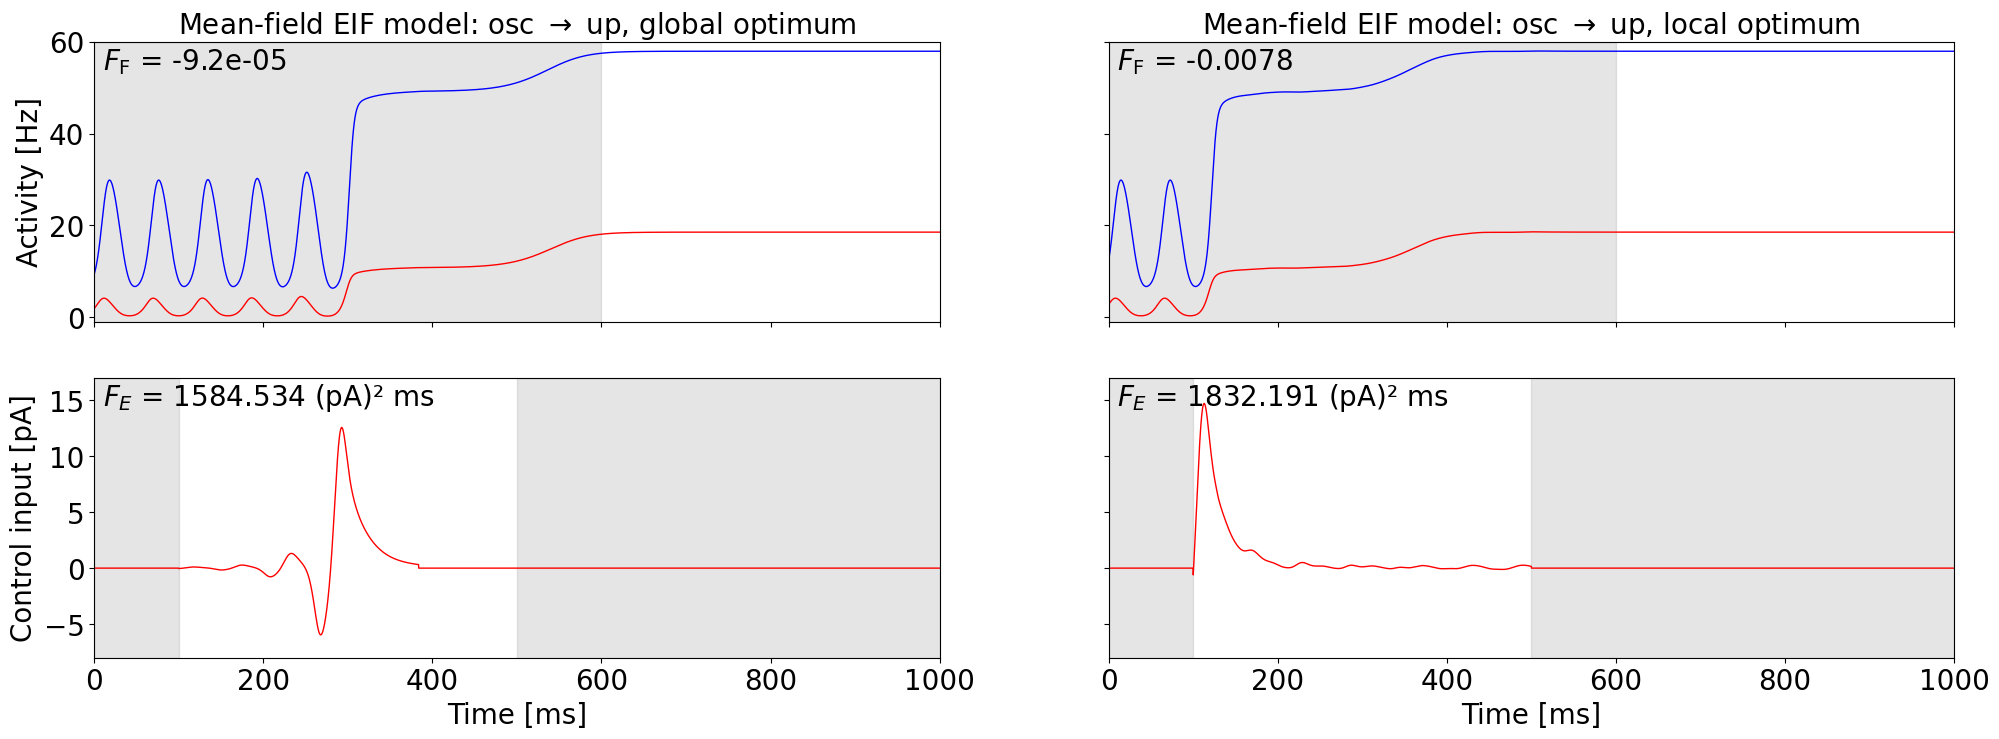

In [179]:
import matplotlib as mpl
label_size= 20
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['font.size'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.linewidth'] = 1

fig, ax = plt.subplots(2,2, figsize=(24,8), sharex=True, sharey="row")

ax[0,0].set_title(r"Mean-field EIF model: osc $\rightarrow$ up, global optimum")
ax[0,1].set_title(r"Mean-field EIF model: osc $\rightarrow$ up, local optimum")

time = np.arange(0, duration+dt, dt)

ax[0,0].plot(time, data["state"][1][0,0,:], color="red", label="E")
ax[0,0].plot(time, data["state"][1][0,1,:], color="blue", label="I")
ax[1,0].plot(time, 200*data["control"][1][0,0,:], color="red")

ax[0,1].plot(time, loc_opt_state[0,0,:], color="red", label="E")
ax[0,1].plot(time, loc_opt_state[0,1,:], color="blue", label="I")
ax[1,1].plot(time, 200*loc_opt_control[0,0,:], color="red")

ax[0,0].set_label("upper right")

ax[1,0].set_xlabel("Time [ms]")
ax[1,1].set_xlabel("Time [ms]")
ax[0,0].set_ylabel("Activity [Hz]")
ax[1,0].set_ylabel("Control input [pA]")

ax[0,0].set_xlim(0, duration)

ax[0,0].set_ylim(-1,60)
ax[1,0].set_ylim(-8,17)

alpha=0.2
for ci in range(2):
    ax[0,ci].axvspan(0, 600, color="grey", alpha=alpha)
    ax[1,ci].axvspan(500, 1000, color="grey", alpha=alpha)
    ax[1,ci].axvspan(0, 100, color="grey", alpha=alpha)

ax[1,0].text(0.01, 0.9, r"$F_E$ = " + "{0:.3f}".format(200**2*data["energy_input"][1]) + " (pA)² ms", transform=ax[1,0].transAxes)
ax[0,0].text(0.01, 0.9, r"$F_\text{F}$ = " + "{0:.2g}".format(data["Fourier_cost"][1]), transform=ax[0,0].transAxes)

ax[1,1].text(0.01, 0.9, r"$F_E$ = " + "{0:.3f}".format(200**2*loc_opt_energy) + " (pA)² ms", transform=ax[1,1].transAxes)
ax[0,1].text(0.01, 0.9, r"$F_\text{F}$ = " + "{0:.2g}".format(loc_opt_fourier), transform=ax[0,1].transAxes)

plt.savefig(os.path.join(datadir, "Fig_S2.jpg"), bbox_inches='tight', dpi=300)